In [28]:
import pandas as pd
import numpy as np
import csv
import os
from datetime import datetime
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Activate the first option if whole column width is necessary and the second to make all columns visible
#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

## I. Import the transformed datasets

In [6]:
#Import the raw RCI score
rci = pd.read_csv('rci_aggegated.csv', index_col = 0)
base = pd.read_csv('factors_clean.csv', index_col = 0)
print(rci.columns)
print(base.columns)
print(rci.shape)
print(base.shape)

Index(['feature_id', 'FinancialY', 'lane', 'avg_score_lane', 'sub_obs_val_max',
       'sub_obs_val_std'],
      dtype='object')
Index(['feature_id', 'survey_feat_end', 'xsp_name', 'LCRV', 'LCTM', 'LEDR',
       'LFAL', 'LGRD', 'LLRT', 'LLTD', 'LLTM', 'LLTX', 'LRRT', 'LRTM', 'LRTC',
       'LRTV', 'LV10', 'LV3', 'FinancialY'],
      dtype='object')
(26766, 6)
(32572, 19)


### I. Dataset formatting

In [7]:
#From the Raw set, separate per feature, financial year and lane
rci.head(5)

,feature_id,FinancialY,lane,avg_score_lane,sub_obs_val_max,sub_obs_val_std
0,A10/104,2009,LEFT,3.940571,33.86,9.027565
1,A10/104,2009,RIGHT,8.481471,77.92,19.711916
2,A10/104,2010,LEFT,7.363529,80.00,15.936653
3,A10/104,2010,RIGHT,17.661429,96.67,27.412318
4,A10/104,2011,LEFT,2.392424,52.79,9.425704


In [14]:
base.head(5)

,feature_id,survey_feat_end,lane,LCRV,LCTM,LEDR,LFAL,LGRD,LLRT,LLTD,LLTM,LLTX,LRRT,LRTM,LRTC,LRTV,LV10,LV3,FinancialY
0,B5378/998,2008-09-20 23:59:59.000,RIGHT,90.164187,0.488438,0.051931,2.991250,-0.217500,5.925786,0.773813,0.526125,0.645937,4.454088,0.439000,0.136875,11.469500,33.335625,4.881812,2009
1,B5378/999,2008-09-20 23:59:59.000,RIGHT,133.517243,0.624522,0.078393,2.980882,-1.488603,6.820000,1.040074,0.729007,0.870662,6.284444,0.656103,0.278676,8.292316,34.846287,4.729485,2009
2,B5378/ALL,2008-09-20 23:59:59.000,RIGHT,70.567493,0.649280,0.068850,2.340634,-1.276945,6.195362,1.018876,0.740317,0.878790,5.738551,0.677089,0.258501,11.571902,32.853141,4.187176,2009
3,C105/20,2008-09-30 23:59:59.000,LEFT,-61.629843,0.785197,0.055858,1.403150,1.040945,6.126772,0.558504,0.618583,0.776404,4.986614,0.872441,0.570079,13.521732,27.395333,3.462441,2009
4,C96/60,2008-09-27 23:59:59.000,LEFT,-73.783689,0.578932,0.071103,-0.215534,2.331068,10.207447,1.141456,0.649126,0.794369,7.683158,0.934466,0.087379,13.825258,51.326505,5.863495,2009


In [9]:
base.loc[(base.xsp_name.str.contains('Left')),'xsp_name']='LEFT'
base.loc[(base.xsp_name.str.contains('Right')),'xsp_name']='RIGHT'

In [13]:
base.rename(columns = {'xsp_name':'lane'}, inplace = True)

#### II. Merge sets

In [15]:
#Add the RCI factors to the general set:
df = rci.merge(base,'left',on=['feature_id', 'FinancialY', 'lane'],left_index = True)
df.reset_index(drop= True, inplace = True)

In [18]:
df.shape

(27158, 22)

In [16]:
df.head(5)

,feature_id,FinancialY,lane,avg_score_lane,sub_obs_val_max,sub_obs_val_std,survey_feat_end,LCRV,LCTM,LEDR,LFAL,LGRD,LLRT,LLTD,LLTM,LLTX,LRRT,LRTM,LRTC,LRTV,LV10,LV3
0,A10/104,2009,LEFT,3.940571,33.86,9.027565,2008-09-15 23:59:59.000,594.904000,0.786571,0.009971,2.477143,1.411429,4.000000,0.884286,0.820000,0.935429,2.554286,0.812286,0.011429,4.410000,12.122286,0.951429
1,A10/104,2009,RIGHT,8.481471,77.92,19.711916,2008-09-15 23:59:59.000,278.137353,0.728529,0.008676,1.135294,-1.694118,3.155882,0.706765,0.633235,0.715882,3.972727,0.681471,0.017647,14.397353,19.884118,0.727059
2,A10/104,2010,LEFT,7.363529,80.00,15.936653,2009-11-18 00:00:00.000,191.450000,0.777059,0.008412,1.582353,1.505882,4.055882,1.054412,0.846765,1.039412,2.097059,0.771765,0.097059,1.508824,11.829412,1.635294
3,A10/104,2010,RIGHT,17.661429,96.67,27.412318,2009-11-18 00:00:00.000,457.924286,0.686061,0.014657,1.234286,-2.011429,2.620000,0.787576,0.678182,0.736000,3.957143,0.805455,0.062857,1.505429,45.800000,1.896970
4,A10/104,2011,LEFT,2.392424,52.79,9.425704,2010-10-13 10:11:00.000,149.567576,0.824242,0.012030,2.693939,1.645455,4.000000,0.904545,0.773636,0.923030,3.103030,0.755455,0.024242,2.436970,10.013636,0.770909


In [24]:
df.isnull().sum()

avg_score_lane    0
LCRV              0
LCTM              0
LEDR              0
LFAL              0
LGRD              0
LLRT              0
LLTD              0
LLTM              0
LLTX              0
LRRT              0
LRTM              0
LRTC              0
LRTV              0
LV10              0
LV3               0
dtype: int64

In [19]:
df.drop(columns=['feature_id','FinancialY','lane','sub_obs_val_max',
                 'sub_obs_val_std','survey_feat_end'], inplace = True)

In [21]:
df.dropna(how='any',inplace = True)

### Prediction Model and Feature importance

In [27]:
#Split dataframe in dependent and independent variables 
x_set = df.iloc[:, 1:]
y_set = df.iloc[:, 0] #THE Y SET WILL BE THE AVG RCI VALUE.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x_set, y_set, test_size=0.2)

In [30]:
print(y_train.shape)
print(X_train.shape)

(19560,)
(19560, 15)


In [25]:
out = pd.cut(df['avg_score_lane'], bins=10)
out.value_counts().reindex(out.cat.categories)

(-0.176, 17.587]      7728
(17.587, 35.174]      7308
(35.174, 52.761]      4816
(52.761, 70.348]      2598
(70.348, 87.935]      1233
(87.935, 105.522]      470
(105.522, 123.109]     196
(123.109, 140.696]      70
(140.696, 158.283]      25
(158.283, 175.87]        7
Name: avg_score_lane, dtype: int64

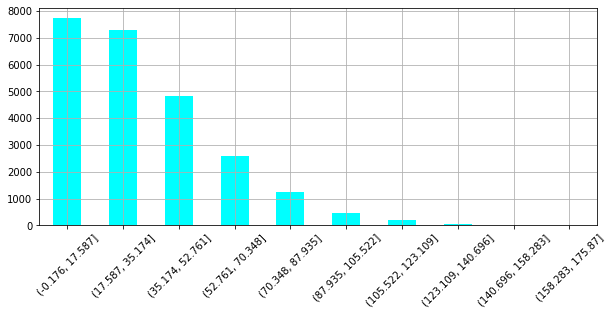

In [31]:
ax = out.value_counts(sort=False).plot.bar(rot=0, color="cyan", figsize=(10,4))
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [32]:
#Divide the target variable into individual columns to test
l_rate = [0.1,0.25,0.5,0.75,1]
for lr in l_rate:
    model = GradientBoostingRegressor(n_estimators=250, learning_rate=lr, 
                           max_features=4, max_depth=4)
    model.fit(X_train,y_train)
    
    print('For ' + str(lr) + ' the RMSE is: ')
    
       
    # predict the target on the train dataset
    predict_train = model.predict(X_train)
    #print('\nTarget on train data',predict_train) 

    # Root Mean Squared Error on train dataset
    rmse_train = sqrt(mean_squared_error(y_train,predict_train)) 
    print('\RMSE on train dataset : ', rmse_train)

    # predict the target on the test dataset
    predict_test = model.predict(X_test)
    #print('\nTarget on test data',predict_test) 

    # Accuracy Score on test dataset
    rmse_test = sqrt(mean_squared_error(y_test,predict_test))
    print('\RMSE on test dataset : ', rmse_test)
    
    score = model.score(X_train,y_train)
    print('\Model score : ', score)

For 0.1 the RMSE is: 
\RMSE on train dataset :  7.955125744656357
\RMSE on test dataset :  9.056463209650971
\Model score :  0.8933607248321741
For 0.25 the RMSE is: 
\RMSE on train dataset :  7.023219117688161
\RMSE on test dataset :  9.302938674866237
\Model score :  0.9168819160486426
For 0.5 the RMSE is: 
\RMSE on train dataset :  6.235393514955974
\RMSE on test dataset :  10.032730016418379
\Model score :  0.9344834800683874
For 0.75 the RMSE is: 
\RMSE on train dataset :  5.699464598145431
\RMSE on test dataset :  10.738938142642445
\Model score :  0.945261712324212
For 1 the RMSE is: 
\RMSE on train dataset :  5.720503574710664
\RMSE on test dataset :  12.02680676453904
\Model score :  0.9448568451278431


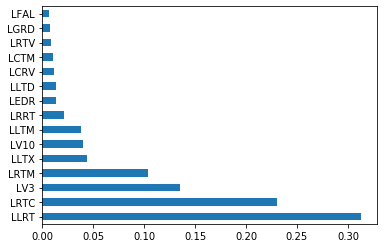

In [33]:
feat_importances = pd.Series(model.feature_importances_, index=x_set.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()